# Dead Tree Mapping

Purpose:        This Script is written as a final project for the Spatial Python course (Eagle master                    programm, teacher Steven Hill)
            
Author:        Reagan Okoth, Nora Nieskens 

Field data:      Tree species identity and their cover on each plot for research extent in Marktheidenfeld (August 2021), Dead tree sampling                      (Source: Mapping campaign by the authors)
                 
Satellite data : 4-Band Planet data, aquisitions in May and September of the years 2018, 2019, 2020, 2021 (Planet Team (2021). Planet Application Program Interface: In Space for Life on Earth. San Francisco, CA. https://api.planet.com); 


Output         : Spatial predicition of dead trees, change detection 

### Problem Rationel

Forest ecosystems are known to provide important ecosystem services including water and air purification. While they play a key role in climate change mitigation as carbon sinks, forests are similarly, very sensitive to the poresent ongoing global climate warming [$^{1}$](https://www.sciencedirect.com/science/article/pii/S0378112710007140?casa_token=eVchPGEdax8AAAAA:IivvV6JwDaHCyOWAAaP724OtaWGStEbTzXcZh-xYFVlYYtZzLnzxzaSkfUuBUdLSD8FtBm1mEpk). During the month of April 2018, a high-pressure system established over Central Europe and lasted almost consistently until mid of October. This resulted in a long-lasting drought spell and record temperatures in central and northern Europe. The impacts of the drought event included deminished ecosystem health especially in forested areas[$^{2}$](https://bg.copernicus.org/preprints/bg-2019-286/bg-2019-286.pdf). In Germany, the warm conditions resulted in Pests such as bark beetle proliferation. As such, the pests' population dramatically escalated to a point they bacame a threat to the foreat ecosystem. As evidence, the Federal Statistical Office (Destatis) reported a record 32 million cubic meteres of timber harvested as a result of pest infestation in the year 2019. These numbers are way overboard when compred to the preceding years (11 and 6 million cubic metere in 2018 and 2017 respectively)[$^{3}$](https://www.destatis.de/EN/Press/2020/07/PE20_N041_412.html).

In this study, we quantify the impact of the 2018-2019 European drought event on forest health using high resolution satellite data in Marktheidenfeld - a small German municipality located along the Main river in the larger Main-Spessert (MSP) region.Our research focused on utilizing Optical Multi-spectral Remote Sensing Imagery (planet data) to descriminate dead trees in a forest ecosystem, estimate the proportion of the forest classified as dead tree, and Investigate the interanual differences in this proportion from 2018 to present. 



# Methods

### Procedure 

- Extract out the forest 

- Classify into  broad leaf vs needle 

- Vegetation health parameters  

- Detect dead tree 

- Investigate temporal changes (e.g. impact of the heat waves 2018, 2019)  

- Change maps in between one year; change maps between the years  

 

- Investigate differences of both forests (left side dead trees standing; right side cut down?) maybe temporal visible --> forest management  

- 2018, 2019, 2020, 2021 Get image from same month/s over 2018-2021 

MAYBE WE DO OUR WORKFLOW AS A GRAPHIC? (lets see in the end) 


In [67]:
#!pip install rasterio

In [68]:
#!pip install --upgrade earthpy

In [69]:
import rasterio
from rasterio.mask import mask
from rasterio.plot import show
import geopandas as gpd
import numpy as np
from shapely.geometry import mapping
import matplotlib.pyplot as plt
import os
import glob
import earthpy.spatial as es
from rasterio.plot import reshape_as_raster, reshape_as_image
from sklearn.cluster import KMeans
from shapely.geometry import mapping
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
from rasterio.plot import show
from rasterio.plot import show_hist
from rasterio.windows import Window
from rasterio.plot import reshape_as_raster, reshape_as_image
import pandas as pd
import re

In [70]:
import os
import numpy as np
import matplotlib.pyplot as plt
import rasterio 
from rasterio.plot import show
import earthpy.spatial as es
import earthpy.plot as ep

Let's load the field data

In [71]:
#Load the field data 
#import geopandas as gpd
field_data = gpd.read_file('../Data/Points_as_Polygon.shp')
#print(field_data)

#map our field data 
field_data.plot

# Reagans Code starts Here

In [72]:
#import geopandas as gpd
import pandas as pd


#shpFile=gpd.read_file('../Data/Merged3.shp')


point_names = field_data.plot_ID

point_names


index = list(range(len(point_names)))
index


name_df = pd.DataFrame(list(zip(list(index), list(point_names))),
                       columns =['index','Name'])
name_df



,index,Name
0,0,F1P1
1,1,F1P2
2,2,F1P3
3,3,F1P4
4,4,F1P5
5,5,F1P6
6,6,F1P7
7,7,F1P8
8,8,F2P1
9,9,F2P2


In [73]:
# Load a csv file containing the coordinates in Latitude and longitude format and not in meters as the shpFile (which is already projected)
# This is because leaflet maps have lat/lon as defauklt projection and not meters

lat_lon_coord = pd.read_csv('../Data/Lat_Lon_coordinates.csv')

index_as_series = pd.Series (index)

index_as_series

0      0
1      1
2      2
3      3
4      4
5      5
6      6
7      7
8      8
9      9
10    10
11    11
12    12
13    13
14    14
15    15
16    16
17    17
18    18
19    19
20    20
21    21
22    22
23    23
24    24
25    25
dtype: int64

In [74]:
lat_lon = lat_lon_coord.iloc[:, 1:3]
#print(lat_lon)

# concancatenate the lat lon with the index series
lat_lon_with_index = pd.concat([index_as_series,lat_lon], axis=1)
lat_lon_with_index.columns = ['index','Lat', 'Lon']
lat_lon_with_index

,index,Lat,Lon
0,0,9.594913,49.837180
1,1,9.590903,49.835934
2,2,9.592406,49.834530
3,3,9.588622,49.828985
4,4,9.585568,49.829090
5,5,9.588138,49.823175
6,6,9.597218,49.817117
7,7,9.583039,49.824209
8,8,9.594470,49.808122
9,9,9.590528,49.809371


In [75]:
# Merge the two dataframes i.e the point names and the lat/lon coordinates based on the index column
new_coord_df = pd.merge(name_df, lat_lon_with_index, on="index")
new_coord_df

,index,Name,Lat,Lon
0,0,F1P1,9.594913,49.837180
1,1,F1P2,9.590903,49.835934
2,2,F1P3,9.592406,49.834530
3,3,F1P4,9.588622,49.828985
4,4,F1P5,9.585568,49.829090
5,5,F1P6,9.588138,49.823175
6,6,F1P7,9.597218,49.817117
7,7,F1P8,9.583039,49.824209
8,8,F2P1,9.594470,49.808122
9,9,F2P2,9.590528,49.809371


In [76]:
from ipyleaflet import Map, Marker,basemaps
center = (new_coord_df.iloc[1,3],new_coord_df.iloc[1,2])
sampling_points = Map(center=center, zoom=13)

for (index, row) in new_coord_df.iterrows():
    marker = Marker(location=[row.loc['Lon'], row.loc['Lat']], 
                       title=row.loc['Name'])
    sampling_points.add_layer(marker)
    
sampling_points

Map(center=[49.8359342934198, 9.59090263783977], controls=(ZoomControl(options=['position', 'zoom_in_text', 'z…

Next, we load the satellite data for each month and stack for each image thebands together. 

In [77]:
#function to filter tif files within the directory, load and stack each imagery
# returns a nupy ndArray. each image is nested in a list, therefore the list is n images long (lenght of the list depend on number of images stacked)
# each image is a 3D array with the following format [x,y,bands]. to index band one for each image for example, one would:
# first index the image of interst from the list i.e list[0] for the first image then index the first band like this list[0][:,:, 1]

def stackRaster(path, raster_extension):
    rasterStack = []
    files = os.listdir(path)
    pattern = re.sub("\.", ".*", raster_extension) + '$'
    filtered = [i for i in files if re.match(pattern, i)]
    
    for file in filtered:
        new_path = os.path.abspath(os.path.join(path, file))
        if os.path.exists(path):
          with rasterio.open(new_path) as src:
            blue, green, red, nir = src.read()
            stack = np.dstack([blue, green, red, nir])
            rasterStack.append(stack)
    return(rasterStack)
                                   

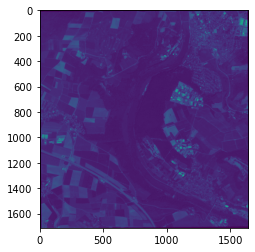

<AxesSubplot:>

In [78]:
# |Implement the above function like this.


path = '../Planet_data/'

Rasterstack = stackRaster(path, '.tif')

# plot the first band of the first image like this
show(Rasterstack[0][:,:,0])


In [79]:
# This function filters files in a directory based on a sprefered file format (extenstion) which is given as the pattern.
# the function returns a list of all thge files meeting the prefred extention.
# the function is based on the regrex library.
import re

def fileFilter(path, pattern):
    files = os.listdir(path)
    new_pattern = re.sub("\.", ".*", pattern) + '$'
    filtered = [i for i in files if re.match(new_pattern, i)]
    return(filtered)

In [80]:
path = '../Planet_data/'

tif_list =  fileFilter(path, '.tif')
xml_list = fileFilter(path, '.xml')
#xml_list

In [81]:
# This function extracts the coeeficients from each image and each band and returns a list of dictionaries. Each dictionary in a list 
# is treated as image. Each dictionary (image) has keys ranging from 1 to 4 corresponding to the PLanet data bands which is in the order of BGRN (1=B and 4=N )
# Key values are the coefficients for indvidual bands that can be used to tranceform the band from radiance to reflectance
# the function takes the path where the files are located and a pattern which corresponds to the file format/extention 
# to be filtrered from the list of files.

from xml.dom import minidom

def getCOEFs(path,pattern ):
    coefs = []
    xml_files = fileFilter(path, pattern)
    for file in xml_files:
        xmldoc = minidom.parse(os.path.join(path, file))
        nodes = xmldoc.getElementsByTagName("ps:bandSpecificMetadata")
        coef_value = {}
        for node in nodes:
            bn = node.getElementsByTagName("ps:bandNumber")[0].firstChild.data
            if bn in ['1', '2', '3', '4']:
                i = int(bn)
                value = node.getElementsByTagName("ps:reflectanceCoefficient")[0].firstChild.data
                coef_value[i] = float(value)
        coefs.append(coef_value)
    return(coefs)  

 
        
    

In [82]:
# get the coefficients and store it in tghe coefficients object as a list of dictionaries.
coefficients = getCOEFs(path, '.xml')

In [83]:
# convert the NIR and RED bands to TOA and use the converted values top compute NDVI

def TOA_ndvi_CALC(stack, coef_list):
    ndvi_stack=[]
    for i in range(len(stack)):
        red = stack[i][:,:,2]
        nir = stack[i][:,:,3]
        
        red_coef = list(coef_list[i].values())[2]
        nir_coef = list(coef_list[i].values())[3]
        
        red_ref = red*red_coef
        nir_ref = nir*nir_coef
        
        ndvi = (nir_ref.astype(float) - red_ref.astype(float)) / (nir_ref.astype(float) + red_ref.astype(float))
        
        ndvi_stack.append(ndvi)
        
    return(ndvi_stack)
        
        
        
        
        

In [84]:
ndvi_stack = TOA_ndvi_CALC(Rasterstack,coefficients)

<ipython-input-83-3a240364f356>:15: RuntimeWarning: invalid value encountered in true_divide
  ndvi = (nir_ref.astype(float) - red_ref.astype(float)) / (nir_ref.astype(float) + red_ref.astype(float))


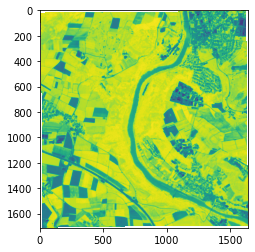

<AxesSubplot:>

In [85]:
show(ndvi_stack[0])

In this section, we perform texture analysis of the scene to create texture features which will aid in classifying pixels as forest or non-forest. Looking at the scene above, we can see that texture information could be very helpful in differentiating the two classes. Texture analysis is performed on a single band. For simplicity, here we will focus on the green band, which is pretty responsive to forest/non-forest.

In [50]:
#create texture feature for the green band 

def get_texture_features(stack):
    green_band = stack[2]
    edges1 = feature.canny(green_band, low_threshold=0.0, high_threshold=0.01, sigma=2)
    blurred = filters.gaussian(edges1, sigma=2)
    blurred2 = filters.gaussian(edges1, sigma=6)
    return [np.ma.array(texture_band, mask=green_band.mask)
            for texture_band in (blurred, blurred2)]

def get_feature_bands(stack):
    texture_bands = get_texture_features(spectral_bands)
    return stack + ndvi + texture_bands

stack_add = []
for i in refl_stacks: 
    j = get_feature_bands()
    stack_add.append(j)

print(stack_add)



NameError: name 'refl_stacks' is not defined

### Forest/ Non-Forest classification



First, we gather our training data. We have one shapefile with forest polygons and one with none forest polygons. We concat both shapefiles together

In [1]:

# Load "non forest" training data
train_data_mask = gpd.read_file('../Data/training_data_forestmask.shp')
train_data_mask

#Concat both shapefiles together. 
forest_train = gpd.GeoDataFrame(pd.concat([field_data, train_data_mask], 
                        ignore_index=True), crs=field_data.crs)
#print(forest_train)

forest_train.geometry.plot()


NameError: name 'gpd' is not defined

In [66]:
pip install GDAL

Note: you may need to restart the kernel to use updated packages.


In [96]:
pip install osgeo

  ERROR: Command errored out with exit status 1:
   command: /Users/rragankonywa/opt/anaconda3/envs/GEE/bin/python -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/private/var/folders/76/s9hr7l0j2rg5xq214qf7vlyw0000gn/T/pip-install-sksg8ont/osgeo_c1128cfd28774abc8be84633ba16680c/setup.py'"'"'; __file__='"'"'/private/var/folders/76/s9hr7l0j2rg5xq214qf7vlyw0000gn/T/pip-install-sksg8ont/osgeo_c1128cfd28774abc8be84633ba16680c/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d /private/var/folders/76/s9hr7l0j2rg5xq214qf7vlyw0000gn/T/pip-wheel-emqxa8lc
       cwd: /private/var/folders/76/s9hr7l0j2rg5xq214qf7vlyw0000gn/T/pip-install-sksg8ont/osgeo_c1128cfd28774abc8be84633ba16680c/
  Complete output (27 lines):
  running bdist_wheel
  running build
  installing to build/bdist.macosx-10.9-x86_64/wheel
  running install
  Traceback (most recent ca

In [95]:
#import GDAL
#import osgeo as osg
from osgeo import gdal, ogr, osr
from osgeo import gdal

forest_train

#test_raster = gdal.open(os.path.abspath(os.path.join(path, file)))
file = tif_list[1]

new_path = os.path.abspath(os.path.join(path, file))
test_raster = gdal.open(os.path.abspath(os.path.join(path, file)))

AttributeError: module 'osgeo.gdal' has no attribute 'open'

In [89]:
from osgeo import gdal
test_raster = gdal.open(os.path.abspath(os.path.join(path, file)))

AttributeError: module 'osgeo.gdal' has no attribute 'open'

In [91]:
!pip list

Package                       Version
----------------------------- -------------------
affine                        2.3.0
aiohttp                       3.7.3
anyio                         2.1.0
appnope                       0.1.2
argon2-cffi                   20.1.0
async-generator               1.10
async-timeout                 3.0.1
attrs                         20.3.0
backcall                      0.2.0
backports.functools-lru-cache 1.6.1
beautifulsoup4                4.9.3
bleach                        3.2.2
bqplot                        0.12.22
branca                        0.4.2
brotlipy                      0.7.0
cachetools                    4.1.1
certifi                       2021.5.30
cffi                          1.14.4
chardet                       3.0.4
click                         7.1.2
click-plugins                 1.1.1
cligj                         0.7.2
colour                        0.1.5
conda                         4.10.3
conda-package-handling        1.7.2
cry

Supervised classification with random forest

In [ ]:
# classify with random forest (stevens script!)





#Calculate some statistics about area changes
#visualize results 

#### Classify into broad leaf vs. needle leaf ######

# Results

- result 1
- result 2
- result ..

# Discusion